# Competencia 1 Kaggle

## 1. Environment Setup

In [1]:
# Clear environment
rm(list = ls(all.names = TRUE))
gc(full = TRUE, verbose = FALSE)

# Load required libraries
require("data.table")
require("parallel")
require("R.utils")
require("primes")
require("utils")
require("rlist")
require("yaml")
require("lightgbm")
require("DiceKriging")
require("mlrMBO")
require("ggplot2")

cat("Libraries loaded successfully\n")
cat("Timestamp:", format(Sys.time(), "%a %b %d %X %Y"), "\n")

,used,(Mb),gc trigger,(Mb),limit (Mb),max used,(Mb)
Ncells,659012,35.2,1462277,78.1,NA,1088797,58.2
Vcells,1225538,9.4,8388608,64.0,32768,2010932,15.4


Loading required package: data.table

Loading required package: parallel

Loading required package: R.utils

Loading required package: R.oo

Loading required package: R.methodsS3

R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.

R.oo v1.27.1 (2025-05-02 21:00:05 UTC) successfully loaded. See ?R.oo for help.


Attaching package: 'R.oo'


The following object is masked from 'package:R.methodsS3':

    throw


The following objects are masked from 'package:methods':

    getClasses, getMethods


The following objects are masked from 'package:base':

    attach, detach, load, save


R.utils v2.13.0 (2025-02-24 21:20:02 UTC) successfully loaded. See ?R.utils for help.


Attaching package: 'R.utils'


The following object is masked from 'package:utils':

    timestamp


The following objects are masked from 'package:base':

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings


Loading required package: primes

Loading required 

Libraries loaded successfully
Timestamp: Tue Oct 07 22:15:19 2025 


## 2. Configuration

In [2]:
# Environment detection and paths
IS_COLAB <- dir.exists("/content/buckets")

if (IS_COLAB) {
  # Colab setup - mount drive first
  # from google.colab import drive
  # drive.mount('/content/.drive')
  
  # Create directory structure
  system("mkdir -p '/content/.drive/My Drive/dmeyf'")
  system("mkdir -p /content/buckets")
  system("ln -s '/content/.drive/My Drive/dmeyf' /content/buckets/b1")
  system("mkdir -p /content/buckets/b1/exp")
  system("mkdir -p /content/buckets/b1/datasets")
  system("mkdir -p /content/datasets")
  
  # Download dataset if needed
  if (!file.exists("/content/buckets/b1/datasets/competencia_01_crudo.csv")) {
    download.file(
      "https://storage.googleapis.com/open-courses/dmeyf2025-e4a2/competencia_01_crudo.csv",
      "/content/buckets/b1/datasets/competencia_01_crudo.csv"
    )
  }
  
  BASE_PATH <- "/content/buckets/b1"
  DATA_PATH <- "/content/datasets/competencia_01_crudo.csv"
} else {
  # Local setup
  setwd('/Users/manumoreira/Repos/dmeyf2025/Competencia1/')
  BASE_PATH <- getwd()
  DATA_PATH <- "./data/competencia_01_crudo.csv"
}

cat("Environment:", ifelse(IS_COLAB, "Colab", "Local"), "\n")
cat("Base path:", BASE_PATH, "\n")
cat("Data path:", DATA_PATH, "\n")

Environment: Local 
Base path: /Users/manumoreira/Repos/dmeyf2025/Competencia1 
Data path: ./data/competencia_01_crudo.csv 


In [3]:
# Experiment parameters
PARAM <- list()
PARAM$experimento <- 8
PARAM$semilla_primigenia <- 450343

# Training periods
PARAM$train <- c(202101, 202102, 202103)
PARAM$train_validate <- c(202101, 202102, 202103)
PARAM$validate <- c(202104)
PARAM$train_final <- c(202101, 202102, 202103, 202104)
PARAM$future <- c(202106)

# Kaggle parameters
PARAM$semilla_kaggle <- 314159
PARAM$cortes <- seq(6000, 19000, by = 500)

# Training strategy
PARAM$trainingstrategy$undersampling <- 0.4

# Hyperparameter tuning
PARAM$hyperparametertuning$xval_folds <- 5
PARAM$hyperparametertuning$iteraciones <- 60

cat("Parameters configured:\n")
cat("  Experiment:", PARAM$experimento, "\n")
cat("  Seed:", PARAM$semilla_primigenia, "\n")
cat("  Training periods:", paste(PARAM$train, collapse = ", "), "\n")
cat("  Validation period:", PARAM$validate, "\n")
cat("  Future period:", PARAM$future, "\n")

Parameters configured:
  Experiment: 8 
  Seed: 450343 
  Training periods: 202101, 202102, 202103 
  Validation period: 202104 
  Future period: 202106 


In [4]:
# LightGBM fixed parameters
PARAM$lgbm$param_fijos <- list(
  boosting = "gbdt",
  objective = "binary",
  metric = "auc",
  first_metric_only = FALSE,
  boost_from_average = TRUE,
  feature_pre_filter = FALSE,
  force_row_wise = TRUE,
  verbosity = -100,
  seed = PARAM$semilla_primigenia,
  max_depth = -1L,
  min_gain_to_split = 0,
  min_sum_hessian_in_leaf = 0.001,
  lambda_l1 = 0.0,
  lambda_l2 = 0.0,
  max_bin = 31L,
  bagging_fraction = 1.0,
  pos_bagging_fraction = 1.0,
  neg_bagging_fraction = 1.0,
  is_unbalance = FALSE,
  scale_pos_weight = 1.0,
  drop_rate = 0.1,
  max_drop = 50,
  skip_drop = 0.5,
  extra_trees = FALSE,
  num_iterations = 1200,
  learning_rate = 0.02,
  feature_fraction = 0.5,
  num_leaves = 750,
  min_data_in_leaf = 3
)

cat("LightGBM fixed parameters configured\n")

LightGBM fixed parameters configured


In [5]:
# Hyperparameter search space
PARAM$hypeparametertuning$hs <- makeParamSet(
  makeIntegerParam("num_iterations", lower = 8L, upper = 2048L),
  makeNumericParam("learning_rate", lower = 0.01, upper = 0.3),
  makeNumericParam("feature_fraction", lower = 0.1, upper = 1.0),
  makeIntegerParam("num_leaves", lower = 8L, upper = 2048L),
  makeIntegerParam("lambda_1", lower = 0, upper = 15),
  makeNumericParam("min_gain_to_split", lower = 0.1, upper = 1.0),
  makeIntegerParam("max_depth", lower = 1, upper = 15),
  makeIntegerParam("bagging_freq", lower = 1, upper = 10),
  makeNumericParam("bagging_fraction", lower = 0.1, upper = 1.0)
)

cat("Hyperparameter search space defined\n")
cat("  Number of hyperparameters to tune:", length(PARAM$hypeparametertuning$hs$pars), "\n")

Hyperparameter search space defined
  Number of hyperparameters to tune: 9 


## 3. Data Loading and Feature Engineering

In [6]:
# Load dataset
dataset <- fread(DATA_PATH, stringsAsFactors = TRUE)

cat("Dataset loaded:\n")
cat("  Rows:", nrow(dataset), "\n")
cat("  Columns:", ncol(dataset), "\n")
cat("  Memory:", format(object.size(dataset), units = "MB"), "\n")

Dataset loaded:
  Rows: 978439 
  Columns: 154 
  Memory: 847.3 Mb 


In [7]:
# Pasar columnas en $ a ranking por mes 

# Function to create separate rankings
rank_separate_by_month <- function(dt, columns, month_col = "foto_mes") {
  new_cols <- paste0(columns, "_ranked")
  
  for(i in seq_along(columns)) {
    col <- columns[i]
    new_col <- new_cols[i]
    
    # Initialize with NAs
    dt[, (new_col) := NA_real_]
    
    # Rank within each month
    dt[!is.na(get(col)), (new_col) := {
      # Handle negatives
      neg_vals <- get(col)[get(col) < 0]
      neg_ranks <- if(length(neg_vals) > 0) -frank(-neg_vals) else numeric(0)
      
      # Handle positives
      pos_vals <- get(col)[get(col) > 0]
      pos_ranks <- if(length(pos_vals) > 0) frank(pos_vals) else numeric(0)
      
      # Handle zeros
      zero_vals <- get(col)[get(col) == 0]
      
      # Combine results
      result <- rep(0, length(get(col)))
      result[get(col) < 0] <- neg_ranks
      result[get(col) > 0] <- pos_ranks
      result[get(col) == 0] <- 0
      result
    }, by = get(month_col)]
  }
  
  return(dt)
}

# Usage:
dataset <- rank_separate_by_month(dataset, c("mrentabilidad", "mrentabilidad_annual", "mcomisiones", "mactivos_margen", "mpasivos_margen", 
                "mcuenta_corriente_adicional", "mcuenta_corriente", "mcaja_ahorro", "mcaja_ahorro_adicional", 
                "mcaja_ahorro_dolares", "mcuentas_saldo", "mautoservicio", "mtarjeta_visa_consumo", "mtarjeta_master_consumo", 
                "mprestamos_personales", "mprestamos_prendarios", "mprestamos_hipotecarios", "mplazo_fijo_dolares", 
                "mplazo_fijo_pesos", "minversion1_pesos", "minversion1_dolares", "minversion2", "mpayroll", "mpayroll2", 
                "mcuenta_debitos_automaticos", "mttarjeta_visa_debitos_automaticos", "mttarjeta_master_debitos_automaticos", 
                "mpagodeservicios", "mpagomiscuentas", "mcajeros_propios_descuentos", "mtarjeta_visa_descuentos", 
                "mtarjeta_master_descuentos", "mcomisiones_mantenimiento", "mcomisiones_otras", "mforex_buy", "mforex_sell", 
                "mtransferencias_recibidas", "mtransferencias_emitidas", "mextraccion_autoservicio", "mcheques_depositados", 
                "mcheques_emitidos", "mcheques_depositados_rechazados", "mcheques_emitidos_rechazados", "matm", "matm_other", 
                "Master_mfinanciacion_limite", "Master_msaldototal", "Master_msaldopesos", "Master_msaldodolares", 
                "Master_mconsumospesos", "Master_mconsumosdolares", "Master_mlimitecompra", "Master_madelantopesos", 
                "Master_madelantodolares", "Master_mpagado", "Master_mpagospesos", "Master_mpagosdolares", 
                "Master_mconsumototal", "Master_mpagominimo", "Visa_mfinanciacion_limite", "Visa_msaldototal", 
                "Visa_msaldopesos", "Visa_msaldodolares", "Visa_mconsumospesos", "Visa_mconsumosdolares", 
                "Visa_mlimitecompra", "Visa_madelantopesos", "Visa_madelantodolares", "Visa_mpagado", "Visa_mpagospesos", 
                "Visa_mpagosdolares", "Visa_mconsumototal", "Visa_mpagominimo"))

In [9]:
# Function to create comparison summary
create_compact_monthly_summary <- function(dt, original_cols, month_col = "foto_mes") {
  ranked_cols <- paste0(original_cols, "_ranked")
  
  summary_list <- lapply(seq_along(original_cols), function(i) {
    orig <- original_cols[i]
    rank <- ranked_cols[i]
    
    month_summary <- dt[!is.na(get(month_col)), .(
      # Original stats
      Orig_Median = median(get(orig), na.rm = TRUE),
      Orig_IQR = IQR(get(orig), na.rm = TRUE),
      Orig_Min = min(get(orig), na.rm = TRUE),
      Orig_Max = max(get(orig), na.rm = TRUE),
      
      # Ranked stats
      Rank_Median = median(get(rank), na.rm = TRUE),
      Rank_IQR = IQR(get(rank), na.rm = TRUE),
      Rank_Min = min(get(rank), na.rm = TRUE),
      Rank_Max = max(get(rank), na.rm = TRUE),
      
      # Counts
      Count = .N,
      Neg_Count_Orig = sum(get(orig) < 0, na.rm = TRUE),
      Zero_Count_Orig = sum(get(orig) == 0, na.rm = TRUE),
      Pos_Count_Orig = sum(get(orig) > 0, na.rm = TRUE),
      Neg_Count_Rank = sum(get(rank) < 0, na.rm = TRUE),
      Zero_Count_Rank = sum(get(rank) == 0, na.rm = TRUE),
      Pos_Count_Rank = sum(get(rank) > 0, na.rm = TRUE),
      NA_Count_Orig = sum(is.na(get(orig))),
      NA_Count_Rank = sum(is.na(get(rank)))
    ), by = month_col]
    
    # Add column name
    month_summary[, Column := orig]
    setcolorder(month_summary, c("Column", month_col, names(month_summary)[!names(month_summary) %in% c("Column", month_col)]))
    
    return(month_summary)
  })
  
  return(rbindlist(summary_list))
}

# Usage
original_cols <- c("mrentabilidad", "mrentabilidad_annual", "mcomisiones", "mactivos_margen", "mpasivos_margen", 
                "mcuenta_corriente_adicional", "mcuenta_corriente", "mcaja_ahorro", "mcaja_ahorro_adicional", 
                "mcaja_ahorro_dolares", "mcuentas_saldo", "mautoservicio", "mtarjeta_visa_consumo", "mtarjeta_master_consumo", 
                "mprestamos_personales", "mprestamos_prendarios", "mprestamos_hipotecarios", "mplazo_fijo_dolares", 
                "mplazo_fijo_pesos", "minversion1_pesos", "minversion1_dolares", "minversion2", "mpayroll", "mpayroll2", 
                "mcuenta_debitos_automaticos", "mttarjeta_visa_debitos_automaticos", "mttarjeta_master_debitos_automaticos", 
                "mpagodeservicios", "mpagomiscuentas", "mcajeros_propios_descuentos", "mtarjeta_visa_descuentos", 
                "mtarjeta_master_descuentos", "mcomisiones_mantenimiento", "mcomisiones_otras", "mforex_buy", "mforex_sell", 
                "mtransferencias_recibidas", "mtransferencias_emitidas", "mextraccion_autoservicio", "mcheques_depositados", 
                "mcheques_emitidos", "mcheques_depositados_rechazados", "mcheques_emitidos_rechazados", "matm", "matm_other", 
                "Master_mfinanciacion_limite", "Master_msaldototal", "Master_msaldopesos", "Master_msaldodolares", 
                "Master_mconsumospesos", "Master_mconsumosdolares", "Master_mlimitecompra", "Master_madelantopesos", 
                "Master_madelantodolares", "Master_mpagado", "Master_mpagospesos", "Master_mpagosdolares", 
                "Master_mconsumototal", "Master_mpagominimo", "Visa_mfinanciacion_limite", "Visa_msaldototal", 
                "Visa_msaldopesos", "Visa_msaldodolares", "Visa_mconsumospesos", "Visa_mconsumosdolares", 
                "Visa_mlimitecompra", "Visa_madelantopesos", "Visa_madelantodolares", "Visa_mpagado", "Visa_mpagospesos", 
                "Visa_mpagosdolares", "Visa_mconsumototal", "Visa_mpagominimo")
rank_summary <- create_compact_monthly_summary(dataset, original_cols)
fwrite(rank_summary, file = "rank_summary.csv", sep = ",")
print(rank_summary)

               Column foto_mes Orig_Median Orig_IQR  Orig_Min  Orig_Max
               <char>    <int>       <num>    <num>     <num>     <num>
  1:    mrentabilidad   202101    1094.090 2957.880 -440340.5  579180.5
  2:    mrentabilidad   202102     952.460 2648.160 -625079.0 1422599.8
  3:    mrentabilidad   202103    1247.720 3277.510 -550651.6  897381.3
  4:    mrentabilidad   202104    1126.795 2969.628 -602558.4  798611.7
  5:    mrentabilidad   202105    1221.970 3045.550 -414139.6  602532.7
 ---                                                                   
434: Visa_mpagominimo   202102    2228.700 5466.180       0.0 2199058.3
435: Visa_mpagominimo   202103    2240.430 5348.880       0.0 1820883.1
436: Visa_mpagominimo   202104    2240.430 5032.170       0.0 3814220.6
437: Visa_mpagominimo   202105    2346.000 5196.390       0.0 4855762.5
438: Visa_mpagominimo   202106    2627.520 5806.350       0.0 2181944.2
     Rank_Median Rank_IQR Rank_Min Rank_Max  Count Neg_Count_Ori

In [8]:
# Create lag and delta features
exclude_fields <- c("numero_de_cliente", "foto_mes", "clase_ternaria")
fields_to_transform <- setdiff(names(dataset), exclude_fields)

cat("Creating lag and delta features...\n")
cat("  Fields to transform:", length(fields_to_transform), "\n")

setorder(dataset, numero_de_cliente, foto_mes)

# Lag features
dataset[, paste0(fields_to_transform, "_lag1") := 
  lapply(.SD, shift, n = 1), 
  by = numero_de_cliente, 
  .SDcols = fields_to_transform]

cat("  Lag features created\n")

# Delta features
dataset[, paste0(fields_to_transform, "_delta1") := 
  lapply(fields_to_transform, function(f) get(f) - get(paste0(f, "_lag1")))]

cat("  Delta features created\n")
cat("  Total columns now:", ncol(dataset), "\n")

Creating lag and delta features...
  Fields to transform: 225 
  Lag features created
  Delta features created
  Total columns now: 677 


In [ ]:
library(data.table)

dataset[, relacion_dependencia := FALSE]

# Identify and update cases that meet the condition
dataset[foto_mes == 202105 & 
     (mpayroll_lag1 / mpayroll) >= 1.3 & 
     (mpayroll_lag1 / mpayroll) <= 1.8, 
   relacion_dependencia := TRUE]
   

In [31]:
cat("La columa relacion dependencia tiene")
dataset[, .N, list(relacion_dependencia)]

La columa relacion dependencia tiene

relacion_dependencia,N
<lgl>,<int>
FALSE,970644
TRUE,7795


## 4. Target Variable Creation (clase_ternaria)

In [33]:
dsimple <- dataset[, list(
    "pos" = .I,
    numero_de_cliente,
    periodo0 = as.integer(foto_mes/100)*12 +  foto_mes%%100 ) ]

setorder( dsimple, numero_de_cliente, periodo0 )

periodo_ultimo <- dsimple[, max(periodo0) ]
periodo_anteultimo <- periodo_ultimo - 1

dsimple[, c("periodo1", "periodo2") :=
    shift(periodo0, n=1:2, fill=NA, type="lead"),  numero_de_cliente ]

dsimple[ periodo0 < periodo_anteultimo, clase_ternaria := "CONTINUA" ]

dsimple[ periodo0 < periodo_ultimo &
    ( is.na(periodo1) | periodo0 + 1 < periodo1 ),
    clase_ternaria := "BAJA+1" ]


dsimple[ periodo0 < periodo_anteultimo & (periodo0+1 == periodo1 )
    & ( is.na(periodo2) | periodo0 + 2 < periodo2 ),
    clase_ternaria := "BAJA+2" ]

setorder( dsimple, pos )
dataset[, clase_ternaria := dsimple$clase_ternaria ]

fwrite( dataset,
    file =  "/Users/manumoreira/Repos/dmeyf2025/Competencia1/data/competencia_01.8.csv.gz",
    
    sep = ","
)

In [34]:
setorder( dataset, foto_mes, clase_ternaria, numero_de_cliente)
dataset[, .N, list(foto_mes, clase_ternaria)]

foto_mes,clase_ternaria,N
<int>,<chr>,<int>
202101,BAJA+1,622
202101,BAJA+2,825
202101,CONTINUA,160080
202102,BAJA+1,831
202102,BAJA+2,1032
202102,CONTINUA,160292
202103,BAJA+1,1039
202103,BAJA+2,951
202103,CONTINUA,161119


## 5. Helper Functions

In [35]:
# Stratified partitioning
particionar <- function(data, division, agrupa = "", campo = "fold", start = 1, seed = NA) {
  if (!is.na(seed)) set.seed(seed, "L'Ecuyer-CMRG")
  
  bloque <- unlist(mapply(
    function(x, y) rep(y, x), 
    division, 
    seq(from = start, length.out = length(division))
  ))
  
  data[, (campo) := sample(rep(bloque, ceiling(.N / length(bloque))))[1:.N], by = agrupa]
}

# Initialize reality dataset for gain evaluation
realidad_inicializar <- function(pfuture, pparam) {
  drealidad <- pfuture[, list(numero_de_cliente, foto_mes, clase_ternaria)]
  particionar(drealidad, division = c(3, 7), agrupa = "clase_ternaria", 
              seed = PARAM$semilla_kaggle)
  return(drealidad)
}

# Evaluate gain (simulates Kaggle split)
realidad_evaluar <- function(prealidad, pprediccion) {
  prealidad[pprediccion, on = c("numero_de_cliente", "foto_mes"), 
            predicted := i.Predicted]
  
  tbl <- prealidad[, list(qty = .N), by = list(fold, predicted, clase_ternaria)]
  
  res <- list()
  res$public <- tbl[fold == 1 & predicted == 1L, 
    sum(qty * ifelse(clase_ternaria == "BAJA+2", 780000, -20000))] / 0.3
  res$private <- tbl[fold == 2 & predicted == 1L, 
    sum(qty * ifelse(clase_ternaria == "BAJA+2", 780000, -20000))] / 0.7
  res$total <- tbl[predicted == 1L, 
    sum(qty * ifelse(clase_ternaria == "BAJA+2", 780000, -20000))]
  
  prealidad[, predicted := NULL]
  return(res)
}

# Objective function for Bayesian Optimization
EstimarGanancia_AUC_lightgbm <- function(x) {
  param_completo <- modifyList(PARAM$lgbm$param_fijos, x)
  
  modelocv <- lgb.cv(
    data = dtrain,
    nfold = PARAM$hyperparametertuning$xval_folds,
    stratified = TRUE,
    param = param_completo
  )
  
  AUC <- modelocv$best_score
  rm(modelocv)
  gc(full = TRUE, verbose = FALSE)
  
  message(format(Sys.time(), "%a %b %d %X %Y"), " AUC ", AUC)
  return(AUC)
}

cat("Helper functions defined\n")

Helper functions defined


## 6. Training Dataset Preparation

In [36]:
# Create experiment directory
exp_name <- sprintf("exp%03d_seed_%d", PARAM$experimento, PARAM$semilla_primigenia)
exp_dir <- file.path(BASE_PATH, "results", exp_name)
dir.create(exp_dir, recursive = TRUE, showWarnings = FALSE)
setwd(exp_dir)

cat("Working directory:", getwd(), "\n")

Working directory: /Users/manumoreira/Repos/dmeyf2025/Competencia1/results/exp008_seed_450343 


In [39]:
# Filter training data
dataset_train <- dataset[foto_mes %in% PARAM$train]

cat("Training dataset:\n")
cat("  Total rows:", nrow(dataset_train), "\n")
print(dataset_train[, .N, by = clase_ternaria])

Training dataset:
  Total rows: 486791 
   clase_ternaria      N
           <char>  <int>
1:         BAJA+1   2492
2:         BAJA+2   2808
3:       CONTINUA 481491


In [40]:
# Apply undersampling
set.seed(PARAM$semilla_primigenia, kind = "L'Ecuyer-CMRG")
dataset_train[, azar := runif(nrow(dataset_train))]
dataset_train[, training := 0L]

dataset_train[
  foto_mes %in% PARAM$train &
    (azar <= PARAM$trainingstrategy$undersampling | 
     clase_ternaria %in% c("BAJA+1", "BAJA+2")),
  training := 1L
]

cat("\nAfter undersampling:\n")
print(dataset_train[training == 1L, .N, by = clase_ternaria])
cat("  Total training rows:", dataset_train[training == 1L, .N], "\n")


After undersampling:
   clase_ternaria      N
           <char>  <int>
1:         BAJA+1   2492
2:         BAJA+2   2808
3:       CONTINUA 192637
  Total training rows: 197937 


In [41]:
# Clase01 binaria de la clase ternaria
dataset_train[,
  clase01 := ifelse(clase_ternaria %in% c("BAJA+2","BAJA+1"), 1L, 0L)
]
# Define features
campos_buenos <- setdiff(
  colnames(dataset_train),
  c("clase_ternaria", "clase01", "azar", "training")
)

cat("Features for training:", length(campos_buenos), "\n")

# Create LightGBM dataset
dtrain <- lgb.Dataset(
  data = data.matrix(dataset_train[training == 1L, campos_buenos, with = FALSE]),
  label = dataset_train[training == 1L, clase01],
  free_raw_data = FALSE
)

cat("LightGBM training dataset created:\n")
cat("  Rows:", nrow(dtrain), "\n")
cat("  Columns:", ncol(dtrain), "\n")

Features for training: 678 
LightGBM training dataset created:
  Rows: 197937 
  Columns: 678 


## 7. Bayesian Optimization

In [42]:
# Configure Bayesian Optimization
kbayesiana <- "bayesiana.RDATA"

configureMlr(show.learner.output = FALSE)

obj.fun <- makeSingleObjectiveFunction(
  fn = EstimarGanancia_AUC_lightgbm,
  minimize = FALSE,
  noisy = TRUE,
  par.set = PARAM$hypeparametertuning$hs,
  has.simple.signature = FALSE
)

ctrl <- makeMBOControl(
  save.on.disk.at.time = 600,
  save.file.path = kbayesiana
)

ctrl <- setMBOControlTermination(ctrl, iters = PARAM$hyperparametertuning$iteraciones)
ctrl <- setMBOControlInfill(ctrl, crit = makeMBOInfillCritEI())

surr.km <- makeLearner(
  "regr.km",
  predict.type = "se",
  covtype = "matern3_2",
  control = list(trace = TRUE)
)

cat("Bayesian Optimization configured\n")
cat("  Iterations:", PARAM$hyperparametertuning$iteraciones, "\n")

Bayesian Optimization configured
  Iterations: 60 


In [ ]:
# Run Bayesian Optimization (this will take a while)
cat("\nStarting Bayesian Optimization...\n")
cat("This may take several hours depending on iterations\n\n")

if (!file.exists(kbayesiana)) {
  bayesiana_salida <- mbo(obj.fun, learner = surr.km, control = ctrl)
} else {
  cat("Continuing from existing bayesiana.RDATA\n")
  bayesiana_salida <- mboContinue(kbayesiana)
}

cat("\nBayesian Optimization completed\n")


Starting Bayesian Optimization...
This may take several hours depending on iterations



Computing y column(s) for design. Not provided.

Tue Oct 07 23:33:22 2025 AUC 0.921650105752358



In [21]:
# Save and analyze results
tb_bayesiana <- as.data.table(bayesiana_salida$opt.path)
tb_bayesiana[, iter := .I]
setorder(tb_bayesiana, -y)

fwrite(tb_bayesiana, file = "BO_log.txt", sep = "\t")

# Extract best hyperparameters
PARAM$out$lgbm$mejores_hiperparametros <- tb_bayesiana[1, 
  setdiff(colnames(tb_bayesiana),
    c("y", "dob", "eol", "error.message", "exec.time", "ei", "error.model",
      "train.time", "prop.type", "propose.time", "se", "mean", "iter")),
  with = FALSE
]

PARAM$out$lgbm$y <- tb_bayesiana[1, y]

cat("\nBest hyperparameters found:\n")
print(PARAM$out$lgbm$mejores_hiperparametros)
cat("\nBest AUC:", PARAM$out$lgbm$y, "\n")

write_yaml(PARAM, file = "PARAM.yml")
cat("\nParameters saved to PARAM.yml\n")


Best hyperparameters found:
   num_iterations learning_rate feature_fraction num_leaves min_data_in_leaf
            <int>         <num>            <num>      <int>            <int>
1:           1752    0.04034412        0.3075806        941             1131
   lambda_1 min_gain_to_split max_depth bagging_freq bagging_fraction
      <int>             <num>     <int>        <int>            <num>
1:       10         0.2101285         7           10        0.8532988

Best AUC: 0.9279649 

Parameters saved to PARAM.yml


## 8. Validation - Final Model Training

In [ ]:
# Prepare final training dataset (includes validation period)
dataset_train_validate <- dataset[foto_mes %in% PARAM$train_validate]

dataset_train_validate[,
  clase01 := ifelse(clase_ternaria %in% c("BAJA+2","BAJA+1"), 1L, 0L)
]

cat("Final training dataset:\n")
cat("  Total rows:", nrow(dataset_train_final), "\n")
print(dataset_train_validate[, .N, by = clase_ternaria])

dtrain_validate <- lgb.Dataset(
  data = data.matrix(dataset_train_validate[, campos_buenos, with = FALSE]),
  label = dataset_train_validate[, clase01]
)

cat("\nLightGBM dataset created for validation training\n")

Final training dataset:
  Total rows: 650209 
   clase_ternaria      N
           <char>  <int>
1:         BAJA+1   2492
2:         BAJA+2   2808
3:       CONTINUA 481491

LightGBM dataset created for final validation training


In [33]:
# Prepare final parameters
param_final <- modifyList(PARAM$lgbm$param_fijos, 
                          PARAM$out$lgbm$mejores_hiperparametros)

# Normalize min_data_in_leaf for full dataset (no undersampling)
param_normalizado <- copy(param_final)
param_normalizado$min_data_in_leaf <- round(
  param_final$min_data_in_leaf / PARAM$trainingstrategy$undersampling
)

cat("Final parameters prepared\n")
cat("  Original min_data_in_leaf:", param_final$min_data_in_leaf, "\n")
cat("  Normalized min_data_in_leaf:", param_normalizado$min_data_in_leaf, "\n")

ERROR: Error in modifyList(PARAM$lgbm$param_fijos, PARAM$out$lgbm$mejores_hiperparametros): is.list(x) is not TRUE


In [61]:
param_final$seed = 876234
print(param_final)

$boosting
[1] "gbdt"

$objective
[1] "binary"

$metric
[1] "auc"

$first_metric_only
[1] FALSE

$boost_from_average
[1] TRUE

$feature_pre_filter
[1] FALSE

$force_row_wise
[1] TRUE

$verbosity
[1] -100

$seed
[1] 876234

$max_depth
[1] 7

$min_gain_to_split
[1] 0.2101285

$min_sum_hessian_in_leaf
[1] 0.001

$lambda_l1
[1] 0

$lambda_l2
[1] 0

$max_bin
[1] 31

$bagging_fraction
[1] 0.8532988

$pos_bagging_fraction
[1] 1

$neg_bagging_fraction
[1] 1

$is_unbalance
[1] FALSE

$scale_pos_weight
[1] 1

$drop_rate
[1] 0.1

$max_drop
[1] 50

$skip_drop
[1] 0.5

$extra_trees
[1] FALSE

$num_iterations
[1] 1752

$learning_rate
[1] 0.04034412

$feature_fraction
[1] 0.3075806

$num_leaves
[1] 941

$min_data_in_leaf
[1] 1131

$lambda_1
[1] 10

$bagging_freq
[1] 10



In [ ]:
# Train final model
cat("\nTraining validate model...\n")
modelo_final <- lgb.train(data = dtrain_validate, param = param_normalizado)
cat("Final model trained successfully\n")


Training final model...
Final model trained successfully


In [47]:
# Feature importance
tb_importancia <- as.data.table(lgb.importance(modelo_final))
fwrite(tb_importancia, file = "impo.txt", sep = "\t")

cat("\nTop 10 most important features:\n")
print(head(tb_importancia, 10))

# Save model
lgb.save(modelo_final, "modelo.txt")
cat("\nModel and importance saved\n")


Top 10 most important features:
                         Feature       Gain       Cover   Frequency
                          <char>      <num>       <num>       <num>
 1:                 ctrx_quarter 0.09168622 0.007585951 0.007440734
 2:            ctrx_quarter_lag1 0.03632740 0.004667321 0.005421930
 3: mtarjeta_visa_consumo_ranked 0.02802941 0.003343210 0.003057046
 4:                     mpayroll 0.02601030 0.005524479 0.002172617
 5:              mpasivos_margen 0.02560428 0.006081457 0.006210225
 6:                 cpayroll_trx 0.02282823 0.004142902 0.001384323
 7:        mcuentas_saldo_ranked 0.01951375 0.005155956 0.006671666
 8:        mprestamos_personales 0.01757724 0.005489490 0.002595605
 9:              mpayroll_ranked 0.01736482 0.005616168 0.002518698
10:            mcuenta_corriente 0.01335849 0.006705296 0.007979081

Model and importance saved


## 9. Validation - Predictions

In [48]:
# Predict on validation set
dvalidate <- dataset[foto_mes %in% PARAM$validate]

cat("Validation dataset:\n")
cat("  Rows:", nrow(dvalidate), "\n")
print(dvalidate[, .N, by = clase_ternaria])

prediccion <- predict(modelo_final, 
  data.matrix(dvalidate[, campos_buenos, with = FALSE]))

cat("\nPredictions generated\n")
cat("  Mean probability:", mean(prediccion), "\n")
cat("  Min probability:", min(prediccion), "\n")
cat("  Max probability:", max(prediccion), "\n")

Validation dataset:
  Rows: 163418 
   clase_ternaria      N
           <char>  <int>
1:         BAJA+1    955
2:         BAJA+2   1130
3:       CONTINUA 161333

Predictions generated
  Mean probability: 0.009016623 
  Min probability: 3.656906e-08 
  Max probability: 0.9767194 


In [49]:
# Prepare prediction table
tb_prediccion <- dvalidate[, list(numero_de_cliente, foto_mes)]
tb_prediccion[, prob := prediccion]

fwrite(tb_prediccion, file = "prediccion.txt", sep = "\t")

# Initialize reality dataset for gain evaluation
drealidad <- realidad_inicializar(dvalidate, PARAM)

cat("Prediction table created and saved\n")

Prediction table created and saved


## 10. Kaggle Submissions (Validation)

In [50]:
# Generate submissions for different cutoffs
setorder(tb_prediccion, -prob)
dir.create("kaggle", showWarnings = FALSE)

gain_results <- data.table()

cat("\n--- Validation Gains ---\n")
cat(sprintf("%-10s %-15s %-15s %-15s %-15s\n", 
            "Envios", "Threshold", "Total", "Public", "Private"))
cat(strrep("-", 70), "\n")

for (envios in PARAM$cortes) {
  tb_prediccion[, Predicted := 0L]
  tb_prediccion[1:envios, Predicted := 1L]
  
  archivo_kaggle <- paste0("./kaggle/KA", PARAM$experimento, "_", envios, ".csv")
  fwrite(tb_prediccion[, list(numero_de_cliente, Predicted)],
    file = archivo_kaggle, sep = ",")
  
  res <- realidad_evaluar(drealidad, tb_prediccion)
  prob_threshold <- tb_prediccion[envios, prob]
  
  gain_results <- rbind(gain_results, data.table(
    envios = envios,
    prob_threshold = prob_threshold,
    gain_total = res$total,
    gain_public = res$public,
    gain_private = res$private
  ))
  
  cat(sprintf("%-10d %-15.6f %-15.0f %-15.0f %-15.0f\n",
    envios, prob_threshold, res$total, res$public, res$private))
}

# Save results
fwrite(gain_results, file = "gain_results.csv")
cat("\nGain results saved to gain_results.csv\n")


--- Validation Gains ---
Envios     Threshold       Total           Public          Private        
---------------------------------------------------------------------- 
6000       0.055502        337600000       288266667       358742857      
6500       0.049741        338800000       285866667       361485714      
7000       0.045196        343200000       293733333       364400000      
7500       0.041246        346000000       294600000       368028571      
8000       0.037627        343200000       291266667       365457143      
8500       0.034692        350800000       304333333       370714286      
9000       0.031943        352000000       304733333       372257143      
9500       0.029513        350800000       303000000       371285714      
10000      0.027190        353600000       309466667       372514286      
10500      0.025397        352400000       308133333       371371429      
11000      0.023403        351200000       303266667       371742857      
11

In [51]:
# Find optimal cutoff
optimal_row <- gain_results[which.max(gain_total)]

cat("\n=== OPTIMAL CUTOFF ===\n")
cat("Envios:", optimal_row$envios, "\n")
cat("Probability threshold:", optimal_row$prob_threshold, "\n")
cat("Total gain:", optimal_row$gain_total, "\n")
cat("Public gain:", optimal_row$gain_public, "\n")
cat("Private gain:", optimal_row$gain_private, "\n")


=== OPTIMAL CUTOFF ===
Envios: 10000 
Probability threshold: 0.02718995 
Total gain: 353600000 
Public gain: 309466667 
Private gain: 372514286 


Warning message:
"Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
i Please use `linewidth` instead."
Warning message in geom_text(aes(x = optimal_row$envios, y = max(gain_total), label = paste("Optimal:", :
"All aesthetics have length 1, but the data has 27 rows.
i Please consider using `annotate()` or provide this layer with data containing
  a single row."



Plots saved:
  - gain_vs_envios.png
  - gain_vs_threshold.png


Warning message in geom_text(aes(x = optimal_row$envios, y = max(gain_total), label = paste("Optimal:", :
"All aesthetics have length 1, but the data has 27 rows.
i Please consider using `annotate()` or provide this layer with data containing
  a single row."


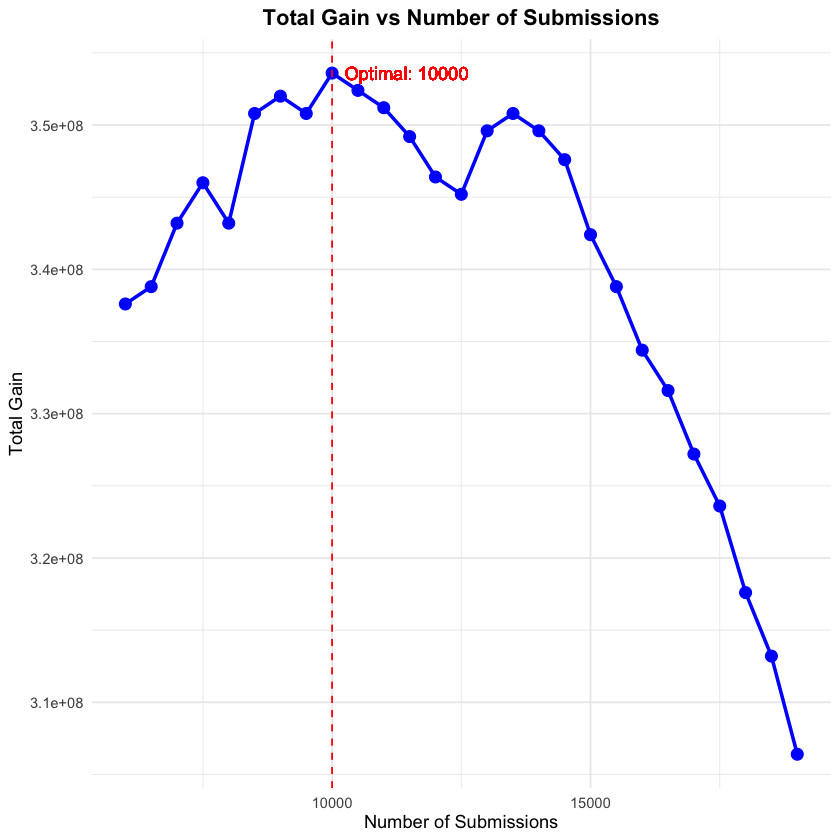

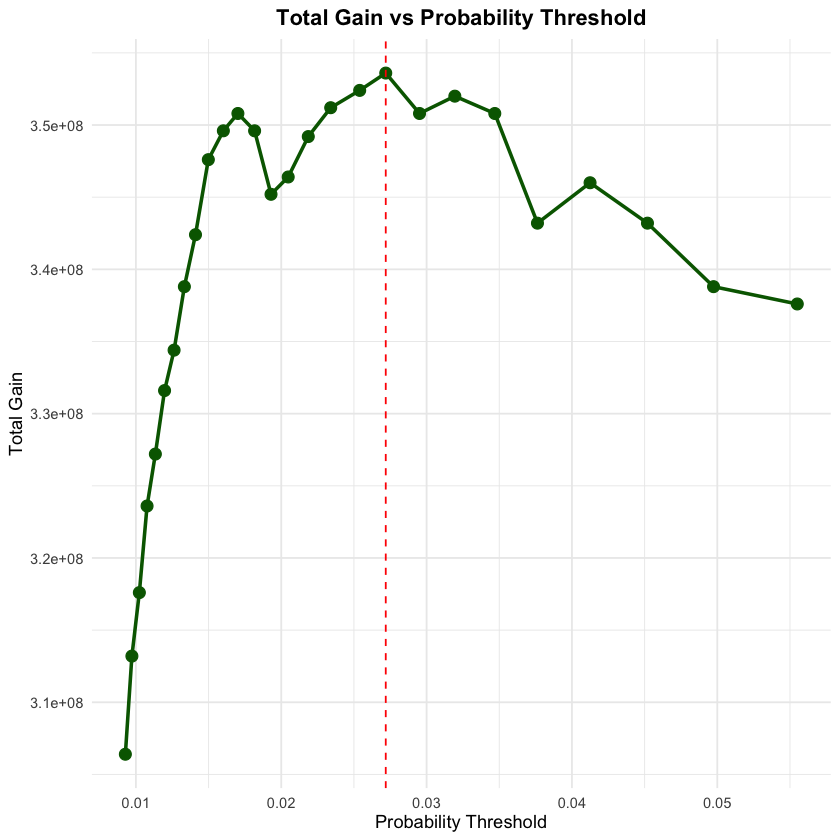

In [52]:
# Plot results
p1 <- ggplot(gain_results, aes(x = envios, y = gain_total)) +
  geom_line(color = "blue", size = 1) +
  geom_point(color = "blue", size = 3) +
  geom_vline(xintercept = optimal_row$envios, linetype = "dashed", color = "red") +
  geom_text(aes(x = optimal_row$envios, y = max(gain_total), 
                label = paste("Optimal:", optimal_row$envios)),
            hjust = -0.1, color = "red") +
  labs(title = "Total Gain vs Number of Submissions",
       x = "Number of Submissions", y = "Total Gain") +
  theme_minimal() +
  theme(plot.title = element_text(hjust = 0.5, face = "bold"))

p2 <- ggplot(gain_results, aes(x = prob_threshold, y = gain_total)) +
  geom_line(color = "darkgreen", size = 1) +
  geom_point(color = "darkgreen", size = 3) +
  geom_vline(xintercept = optimal_row$prob_threshold, linetype = "dashed", color = "red") +
  labs(title = "Total Gain vs Probability Threshold",
       x = "Probability Threshold", y = "Total Gain") +
  theme_minimal() +
  theme(plot.title = element_text(hjust = 0.5, face = "bold"))

ggsave("gain_vs_envios.png", p1, width = 10, height = 6)
ggsave("gain_vs_threshold.png", p2, width = 10, height = 6)

cat("\nPlots saved:\n")
cat("  - gain_vs_envios.png\n")
cat("  - gain_vs_threshold.png\n")

print(p1)
print(p2)

=== DEBUG: Starting analysis ===
1. Checking object existence...
   param_normalizado exists: TRUE 
   dtrain_validate exists: TRUE 
   dvalidate exists: TRUE 
   campos_buenos exists: TRUE 
   PARAM exists: TRUE 
2. Checking object types...
   param_normalizado type: list 
   param_normalizado length: 31 
   dtrain_validate type: lgb.Dataset R6 
   dvalidate dimensions: 163418 678 
   campos_buenos length: 677 
3. About to start loop...


In [ ]:
options(scipen = 999)
stability_seeds <- c(450421, 450599, 862019)
stability_results <- data.table()

cat("=== DEBUG: Starting analysis ===\n")

# Check if objects exist
cat("1. Checking object existence...\n")
cat("   param_normalizado exists:", exists("param_normalizado"), "\n")
cat("   dtrain_validate exists:", exists("dtrain_validate"), "\n") 
cat("   dvalidate exists:", exists("dvalidate"), "\n")
cat("   campos_buenos exists:", exists("campos_buenos"), "\n")
cat("   PARAM exists:", exists("PARAM"), "\n")

# Check object types and sizes
cat("2. Checking object types...\n")
if(exists("param_normalizado")) {
  cat("   param_normalizado type:", class(param_normalizado), "\n")
  cat("   param_normalizado length:", length(param_normalizado), "\n")
}

if(exists("dtrain_validate")) {
  cat("   dtrain_validate type:", class(dtrain_validate), "\n")
}

if(exists("dvalidate")) {
  cat("   dvalidate dimensions:", dim(dvalidate), "\n")
}

if(exists("campos_buenos")) {
  cat("   campos_buenos length:", length(campos_buenos), "\n")
}

cat("3. About to start loop...\n")
for (seed_idx in seq_along(stability_seeds)) {
  cat("Seed iteration:", seed_idx, "of", length(stability_seeds), "\n")
  
  param_test <- param_normalizado
  param_test$seed <- stability_seeds[seed_idx]
  cat("  Parameters prepared\n")
  
  # Check if training data is valid
  cat("  Training data check...\n")
  cat("    dtrain_validate dimensions:", dim(dtrain_validate), "\n")
  
  # Train the model - this is likely where it hangs
  cat("  Starting model training...\n")
  modelo_test <- lgb.train(data = dtrain_validate, param = param_test)
  cat("  Model training completed\n")  # If you don't see this, training is hanging
  
  # If we get here, the rest should work
  cat("  Making predictions...\n")
  prediccion_test <- predict(modelo_test, 
    data.matrix(dvalidate[, campos_buenos, with = FALSE]))
  
  cat("  Creating results table...\n")
  tb_test <- dvalidate[, list(numero_de_cliente, foto_mes)]
  tb_test[, prob := prediccion_test]
  
  drealidad <- realidad_inicializar(dvalidate, PARAM)
  setorder(tb_test, -prob)
  
  cat("\n--- Seed:", stability_seeds[seed_idx], "---\n")
  cat(sprintf("%-10s %-15s %-15s\n", "Envios", "Threshold", "Total"))
  cat(strrep("-", 40), "\n")
  
  # Pre-allocate results for this seed
  seed_results <- list()
  
  for (i in seq_along(PARAM$cortes)) {
    envios <- PARAM$cortes[i]
    tb_test[, Predicted := 0L]
    tb_test[1:envios, Predicted := 1L]
    
    res <- realidad_evaluar(drealidad, tb_test)
    prob_threshold <- tb_test[envios, prob]
    
    seed_results[[i]] <- data.table(
      seed = stability_seeds[seed_idx],
      envios = envios,
      prob_threshold = prob_threshold,
      gain_total = res$total
    )
    
    cat(sprintf("%-10d %-15.6f %-15.0f\n",
      envios, prob_threshold, res$total))
  }
  
  # Combine results for this seed
  stability_results <- rbindlist(list(stability_results, rbindlist(seed_results)))
}

# Optional: Clean up memory
gc()

=== DEBUG: Starting analysis ===
1. Checking object existence...
   param_normalizado exists: TRUE 
   dtrain_validate exists: TRUE 
   dvalidate exists: TRUE 
   campos_buenos exists: TRUE 
   PARAM exists: TRUE 
2. Checking object types...
   param_normalizado type: list 
   param_normalizado length: 31 
   dtrain_validate type: lgb.Dataset R6 
   dvalidate dimensions: 163418 678 
   campos_buenos length: 677 
3. About to start loop...


## 11. Production (Final Prediction)

In [ ]:
# Train production model on ALL final training data
cat("\n=== TRAINING PRODUCTION MODEL ===\n")

dfinal <- dataset[foto_mes %in% PARAM$train_final]

cat("Production training dataset:\n")
print(dfinal[, .N, by = clase_ternaria])

dfinal_lgb <- lgb.Dataset(
  data = data.matrix(dfinal[, campos_buenos, with = FALSE]),
  label = dfinal[, clase01]
)

modelo_produccion <- lgb.train(data = dfinal_lgb, param = param_normalizado)
cat("\nProduction model trained successfully\n")

In [ ]:
# Predict on future data
dpredict <- dataset[foto_mes %in% PARAM$future]

cat("\nFuture dataset for prediction:\n")
cat("  Rows:", nrow(dpredict), "\n")
cat("  Period:", PARAM$future, "\n")

probs_future <- predict(modelo_produccion, 
  data.matrix(dpredict[, campos_buenos, with = FALSE]))

cat("\nPredictions generated\n")
cat("  Mean probability:", mean(probs_future), "\n")
cat("  Min probability:", min(probs_future), "\n")
cat("  Max probability:", max(probs_future), "\n")

In [ ]:
# Create final prediction table
tb_pred_final <- data.table(
  numero_de_cliente = dpredict$numero_de_cliente,
  prob = probs_future
)

setorder(tb_pred_final, -prob)

# Apply optimal cutoff from validation
ENVIOS_OPTIMO <- gain_results[which.max(gain_total), envios]

tb_pred_final[, Predicted := 0L]
tb_pred_final[1:ENVIOS_OPTIMO, Predicted := 1L]

cat("\n=== FINAL SUBMISSION ===\n")
cat("Optimal number of submissions:", ENVIOS_OPTIMO, "\n")
cat("Predicted BAJA+2:", sum(tb_pred_final$Predicted), "\n")
cat("Percentage:", round(100 * sum(tb_pred_final$Predicted) / nrow(tb_pred_final), 2), "%\n")

# Save final submission
fwrite(tb_pred_final[, list(numero_de_cliente, Predicted)], 
  file = "prediccion_final.csv", sep = ",")

# Also save with probabilities for analysis
fwrite(tb_pred_final, file = "prediccion_final_with_probs.csv", sep = ",")

cat("\nFiles saved:\n")
cat("  - prediccion_final.csv (for Kaggle submission)\n")
cat("  - prediccion_final_with_probs.csv (for analysis)\n")

## 12. Summary

In [ ]:
# Final summary
cat("\n", strrep("=", 70), "\n")
cat("EXPERIMENT SUMMARY\n")
cat(strrep("=", 70), "\n\n")

cat("Configuration:\n")
cat("  Experiment:", PARAM$experimento, "\n")
cat("  Seed:", PARAM$semilla_primigenia, "\n")
cat("  Training periods:", paste(PARAM$train, collapse = ", "), "\n")
cat("  Validation period:", PARAM$validate, "\n")
cat("  Future period:", PARAM$future, "\n")
cat("  Undersampling:", PARAM$trainingstrategy$undersampling, "\n")

cat("\nBayesian Optimization:\n")
cat("  Iterations:", PARAM$hyperparametertuning$iteraciones, "\n")
cat("  Best AUC:", PARAM$out$lgbm$y, "\n")

cat("\nValidation Results:\n")
cat("  Optimal envios:", optimal_row$envios, "\n")
cat("  Optimal threshold:", round(optimal_row$prob_threshold, 6), "\n")
cat("  Expected total gain:", optimal_row$gain_total, "\n")
cat("  Expected public gain:", optimal_row$gain_public, "\n")
cat("  Expected private gain:", optimal_row$gain_private, "\n")

cat("\nFinal Prediction:\n")
cat("  Total customers:", nrow(tb_pred_final), "\n")
cat("  Predicted BAJA+2:", sum(tb_pred_final$Predicted), "\n")
cat("  Submission file: prediccion_final.csv\n")

cat("\nOutput directory:", getwd(), "\n")
cat("\nCompleted:", format(Sys.time(), "%a %b %d %X %Y"), "\n")
cat(strrep("=", 70), "\n")